In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import json
import os
import tqdm
import decord
from decord import VideoReader
decord.bridge.set_bridge("torch")
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import math
from typing import Dict, Optional, Sequence, List


class AnnotationLoader:
    def __init__(self, train_path, val_path, origin_path, EGO4D_JSON_PATH):
        self.train_data = json.load(open(train_path))
        self.val_data = json.load(open(val_path))
        self.data = {**self.train_data, **self.val_data}
        
        self.origin_narration = json.load(open(origin_path))['videos']
        
        meta_data = json.load(open(EGO4D_JSON_PATH))['videos']
        self.meta_data = {}
        for meta_d in meta_data:
            self.meta_data[meta_d['video_uid']] = meta_d
        
    def get_data(self):
        return self.data
    
    def get_origin_narration(self):
        return self.origin_narration
    
    def get_meta_data(self):
        return self.meta_data

class CaptionGenerator:
    def __init__(self, model_name, tokenizer_name, device='cuda:4', dtype=torch.bfloat16):
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True,
                                               attn_implementation='sdpa', torch_dtype=dtype)
        self.model.eval()
        self.model.to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, trust_remote_code=True)
            
    def get_caption(self, frames, question):
        msgs = [
            {'role': 'user', 'content': frames + [question]}, 
        ]
        
        # Set decode params for video
        params={}
        params["use_image_id"] = False
        params["max_slice_nums"] = 2 # use 1 if cuda OOM and video resolution >  448*448

        answer = self.model.chat(
            image=None,
            msgs=msgs,
            tokenizer=self.tokenizer,
            **params
        )
        return question, answer
device = 'cuda:3'
caption_generator = CaptionGenerator('openbmb/MiniCPM-V-2_6', 'openbmb/MiniCPM-V-2_6', device)
train_path = '/root/videollm-online/datasets/ego4d/v2/annotations/refined_narration_stream_train.json'
val_path = '/root/videollm-online/datasets/ego4d/v2/annotations/refined_narration_stream_val.json'
origin_path = '/root/videollm-online/datasets/ego4d/v2/annotations/all_narrations_redacted.json'
EGO4D_JSON_PATH = "/root/videollm-online/datasets/ego4d/ego4d.json"

annotation_loader = AnnotationLoader(train_path, val_path, origin_path, EGO4D_JSON_PATH)
data = annotation_loader.get_data()
origin_data = annotation_loader.get_origin_narration()
meta_data = annotation_loader.get_meta_data()

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


334
17
torch.Size([17, 1080, 1440, 3])
time: 390.0
time: 420.0
time: 430.0


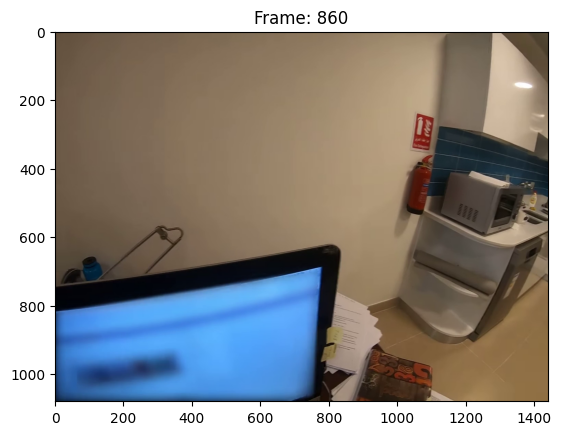

In [26]:
import decord
from decord import VideoReader
decord.bridge.set_bridge("torch")
import os, math
from PIL import Image
def ceil_time_by_fps(time: float, fps: int, min_time: float, max_time: float):
    return min(max(math.ceil(time * fps) / fps, min_time), max_time)

video_root = '/root/videollm-online/datasets/ego4d/v2/full_scale_2fps'
video_uid_clip_uid = '002ad105-bd9a-4858-953e-54e88dc7587e_b0805f53-e98b-4ce6-9653-d65a30ea383e_qa'
video_uid = video_uid_clip_uid.split('_')[0]
clip_uid = video_uid_clip_uid.split('_')[1]
frame_fps = 2

summs = origin_data[video_uid]['summaries']
for summ in summs:
    if summ['_annotation_uid'] == clip_uid:
        break
start_time = summ['start_time']
end_time = summ['end_time']
vr = VideoReader(os.path.join(video_root, video_uid + '.mp4'))


question = 'I need to check my emails. Where should I go? '
answer = 'The computer monitor displaying an email interface is located on the desk in the office area. Move to the desk to access your emails.'
question_time = 19.830206999999998  
answer_time = 436.1996055030303

start_frame = int(ceil_time_by_fps(start_time, frame_fps, 0, (vr._num_frame-1) / frame_fps) * frame_fps)
end_frame = int(ceil_time_by_fps(answer_time, frame_fps, 0, (vr._num_frame-1) / frame_fps)* frame_fps) + 1

sample_ratio = 0.05
load_frames = list(range(start_frame, end_frame))
print(len(load_frames))
sample_frames_idx = load_frames[::int(1/sample_ratio)]
print(len(sample_frames_idx))

sample_frames = vr.get_batch(sample_frames_idx)
print(sample_frames.shape)
sample_frames = [Image.fromarray(frame.numpy().astype('uint8')) for frame in sample_frames]

system_prompt = open('/root/videollm-online/data/estp/time_verifed_system_prompt_v2.txt').read()
output_dir = f'/root/videollm-online/data/estp/output_{video_uid}_v2'
os.makedirs(output_dir, exist_ok=True)
# prompt = system_prompt.format(QUESTION=question, ANSWER=answer)
prompt = system_prompt.format(OBJECT='Computer Monitor')
for frame, idx in zip(sample_frames, sample_frames_idx):
    frames = [frame]
    prompt, answer = caption_generator.get_caption(frames, prompt)
    if answer.lower().startswith('yes'):
        print(f'time: {idx / frame_fps}')
    plt.imshow(frame)
    plt.title(f'Frame: {idx}')
    plt.savefig(f'{output_dir}/{idx}.png')
    with open(f'{output_dir}/{idx}.txt', 'w') as f:
        f.write(f'{prompt}\n{answer}')

In [8]:
print(sample_frames[0].size)

(1440, 1080)


KeyboardInterrupt: 

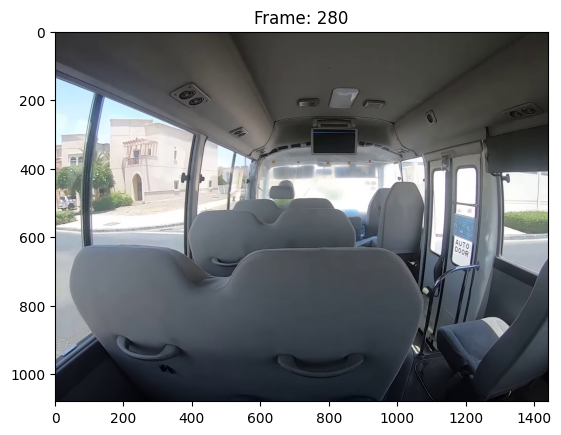